<a href="https://colab.research.google.com/github/Lego514/Lego514/blob/main/LunarLander_v2(DQN_PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# DQN Algorithm on the Lunar Lander 
# Install
!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
# Imports
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [3]:
# Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

One such popular algorithm is the Deep Q-Network (DQN). This algorithm makes use of deep neural networks to compute optimal actions. 

LunarLander_v2 consists of the lander and a landing pad marked by two flags. The episode starts with the lander moving downwards due to gravity. The objective is to land safely using different engines available on the lander with zero speed on the landing pad as quickly and fuel efficient as possible. Reward for moving from the top of the screen and landing on landing pad with zero speed is between 100 to 140 points. Each leg ground contact yields a reward of 10 points. Firing main engine leads to a reward of -0.3 points in each frame. Firing the side engine leads to a reward of -0.03 points in each frame. An additional reward of -100 or +100 points is received if the lander crashes or comes to rest respectively which also leads to end of the episode.

The input state of the Lunar Lander consists of following components:
  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

The actions of the agents are:
  1. Do Nothing
  2. Fire Main Engine
  3. Fire Left Engine
  4. Fire Right Engine

In [4]:
# Basic DQN Implementation
nn_layers = [64,64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
             #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001  #This is the step-size with which the gradient descent is carried out.
             #Tip: Use smaller step-sizes for larger networks.

In [5]:
# Setup our model and the DQN algorithm.
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env = gym.make('LunarLander-v2')

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env,log_path = log_dir, deterministic=True) 
#For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)


model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  #for simplicity, we are not doing batch update.
            buffer_size=1, #size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1, #learning starts immediately!
            gamma=0.95, #discount facto. range is between 0 and 1.
            tau = 1,  #the soft update coefficient for updating the target network
            target_update_interval=1, #update the target network immediately.
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 1, #initial value of random action probability
            exploration_fraction = 0.5, #fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1, #number of gradient steps
            seed = 1, #seed for the pseudo random generators
            verbose=0) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.


# You can also experiment with other RL algorithms like A2C, PPO, DDPG etc. Refer to  https://stable-baselines3.readthedocs.io/en/master/guide/examples.html
#for documentation. For example, if you would like to run DDPG, just replace "DQN" above with "DDPG".

In [6]:
# run LunarLander before training
test_env = wrap_env(gym.make("LunarLander-v2"))
observation = test_env.reset()
total_reward = 0
while True:
  test_env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info = test_env.step(action)
  total_reward += reward
  if done:
    break;

print("reward:",total_reward)
test_env.close()
show_video()

reward: -188.81050197594394


## Deep Q Network（DQN）


In [7]:
# Training DQN
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
# The performance of the training will be printed every 10 episodes. Change it to 1, if you wish to
# view the performance at every training episode.

Eval num_timesteps=10000, episode_reward=-2081.10 +/- 317.77
Episode length: 266.00 +/- 25.31
New best mean reward!
Eval num_timesteps=20000, episode_reward=-104.20 +/- 24.52
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=-113.26 +/- 29.06
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-42.15 +/- 32.04
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=101.35 +/- 99.35
Episode length: 584.20 +/- 47.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=-114.91 +/- 17.52
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=70000, episode_reward=56.07 +/- 119.39
Episode length: 447.00 +/- 36.55
Eval num_timesteps=80000, episode_reward=-134.69 +/- 177.83
Episode length: 613.00 +/- 223.23
Eval num_timesteps=90000, episode_reward=-165.52 +/- 48.45
Episode length: 680.80 +/- 140.92
Eval num_timesteps=100000, episode_reward=-217.76 +/- 84.78
Episode length: 498.80

In [12]:
#visualize the performance
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

Text(0, 0.5, 'Episode Rewards')

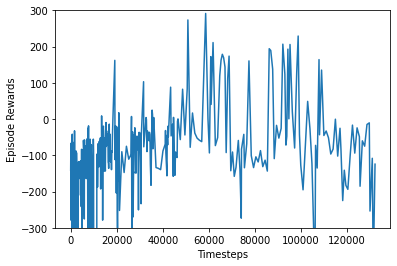

In [13]:
#  Analyze
x, y = ts2xy(load_results(log_dir), 'timesteps')  
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

## Use Proximal Policy Optimization (PPO) algorithm

In [7]:
#Use Proximal Policy Optimization (PPO) algorithm

from stable_baselines3 import PPO
del model 
model = PPO('MlpPolicy', env, verbose=0)

In [8]:
# Training 
model.learn(total_timesteps=100000, log_interval=10, callback=callback)

Eval num_timesteps=10000, episode_reward=-1152.59 +/- 534.07
Episode length: 175.80 +/- 52.69
New best mean reward!
Eval num_timesteps=20000, episode_reward=-2247.45 +/- 1443.49
Episode length: 290.60 +/- 98.21
Eval num_timesteps=30000, episode_reward=-1129.27 +/- 793.31
Episode length: 437.00 +/- 182.19
New best mean reward!
Eval num_timesteps=40000, episode_reward=-333.56 +/- 145.17
Episode length: 244.20 +/- 68.23
New best mean reward!
Eval num_timesteps=50000, episode_reward=-203.61 +/- 63.72
Episode length: 429.40 +/- 120.40
New best mean reward!
Eval num_timesteps=60000, episode_reward=-129.93 +/- 79.69
Episode length: 887.00 +/- 197.82
New best mean reward!
Eval num_timesteps=70000, episode_reward=-114.55 +/- 68.05
Episode length: 748.20 +/- 190.21
New best mean reward!
Eval num_timesteps=80000, episode_reward=-46.78 +/- 123.18
Episode length: 633.20 +/- 206.31
New best mean reward!
Eval num_timesteps=90000, episode_reward=114.50 +/- 133.39
Episode length: 584.60 +/- 57.17
New b

In [15]:
#visualize the performance
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

Text(0, 0.5, 'Episode Rewards')

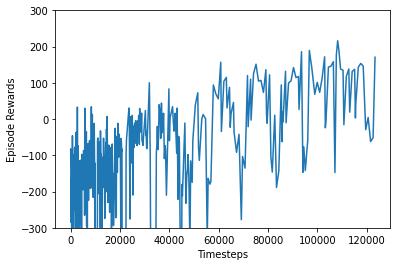

In [10]:
#  Analyze
x, y = ts2xy(load_results(log_dir), 'timesteps') 
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')

## DQN Modify the model parameters & Increase the number of samples for training

In [7]:
del model 
model = DQN(
    "MlpPolicy", 
    env=env, 
    learning_rate=5e-4,
    batch_size=128,
    buffer_size=50000,
    learning_starts=0,
    target_update_interval=250,
    policy_kwargs={"net_arch" : [256, 256]},
    verbose=0,
    tensorboard_log="./tensorboard/LunarLander-v2/"
)

In [8]:
model.learn(total_timesteps=500000, log_interval=10, callback=callback)

Eval num_timesteps=10000, episode_reward=-140.72 +/- 18.80
Episode length: 910.60 +/- 112.90
New best mean reward!
Eval num_timesteps=20000, episode_reward=-188.25 +/- 31.68
Episode length: 311.60 +/- 76.60
Eval num_timesteps=30000, episode_reward=-73.81 +/- 12.38
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-22.78 +/- 16.55
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=-9.38 +/- 9.30
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=-50.13 +/- 92.48
Episode length: 841.60 +/- 316.80
Eval num_timesteps=70000, episode_reward=-31.08 +/- 45.79
Episode length: 869.80 +/- 260.40
Eval num_timesteps=80000, episode_reward=-18.78 +/- 28.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=90000, episode_reward=-111.19 +/- 154.99
Episode length: 825.80 +/- 348.40
Eval num_timesteps=100000, episode_reward=116.42 +/- 99.52
Episode length: 809.80 +/- 1

In [9]:
env = wrap_env(gym.make("LunarLander-v2"))
observation = env.reset()
while True:
  env.render()
  action, _states = model.predict(observation, deterministic=True)
  observation, reward, done, info = env.step(action)
  if done:
    break;

env.close()
show_video()

Text(0, 0.5, 'Episode Rewards')

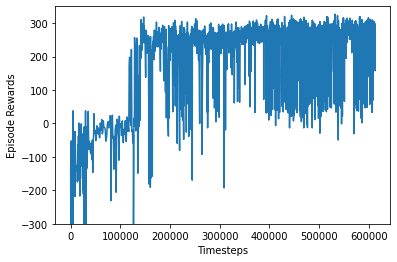

In [10]:
#  Analyze
x, y = ts2xy(load_results(log_dir), 'timesteps')  
plt.plot(x,y)
plt.ylim([-300, 350])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')